In [7]:
import pennylane as qml
from pennylane import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from qubit_models import *
from helpers import *

In [8]:
from datasets import *

train_X, test_X, train_y, test_y = get_xor_data(500)
# train_X, test_X, train_y, test_y = get_circular_boundary_dataset(500)
len(train_X)

450

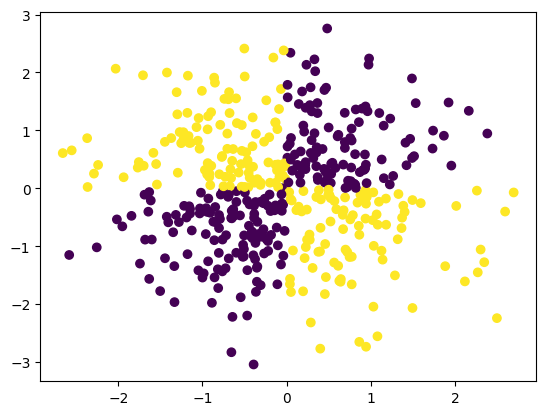

In [9]:
plot_2d_data(train_X,train_y)

In [27]:
s_params_size=3

In [28]:
dev = qml.device("default.qubit", wires=1)

In [29]:
@qml.qnode(dev)
def vqc_model(x_i, params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
#     encode_and_rotate(x_i, s_params,w_params)
    # scheme_a(x_i, s_params,w_params)
    # scheme_e(x_i, s_params,w_params)
    scheme_f(x_i, s_params,w_params)
    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev)
def get_state(x_i,params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    encode_and_rotate(x_i, s_params,w_params)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]


In [30]:
def loss(data, labels, model, params):    
    loss_sum = []
    for idx in range(len(data)):
        data_point = data[idx]
        true_label = labels[idx]
        model_output = model(data_point, params)
        if (model_output<0 and true_label>0) or (model_output>0 and true_label<0):
#             print(model_output, true_label)
            loss_sum.append((model_output - true_label) ** 2)

    return sum(loss_sum)/len(data)
#     return sum(loss_sum)/len(loss_sum)
#     return loss_sum / len(data)


def make_prediction(model, data_point, params):
    measurement_result = model(data_point, params)
    if measurement_result < 0:
        return -1
    return 1


def compute_accuracy(data, labels, model, params):
    n_samples = len(data)
#     for x in range(n_samples):
#         print(make_prediction(model, data[x], params),labels[x])
    return np.sum(
        [make_prediction(model, data[x], params) == labels[x] for x in range(n_samples)
    ]) / n_samples

In [31]:
def get_initial_dataset(train_X,train_Y):
    size_to_return = int(0.04*len(train_X))
    curr_train_X, curr_train_y = [],[]
    idx = np.random.choice(len(train_X), size_to_return)
    for i in idx:
        curr_train_X.append(train_X[i])        
        curr_train_y.append(train_Y[i])
    curr_train_X = np.array(curr_train_X, requires_grad=False)
    curr_train_y = np.array(curr_train_y, requires_grad=False)
    return curr_train_X,curr_train_y

In [32]:
# start_point_itrs = 50

# for _ in range(start_point_itrs):
# print("__________________________________________________")
s_params_size, w_params_size = 3,3
params = np.random.normal(size=(s_params_size+w_params_size))#*100
# params = np.array([ 1.00302379, -0.03861783,  0.08039802,  1.81841197]) # these weights work very well with circular boundary
print(params)
# opt = qml.AdamOptimizer(stepsize=0.00087)
opt = qml.GradientDescentOptimizer(stepsize=0.009)
num_its = 220
loss_over_time = []
# curr_train_X, curr_train_y = get_initial_dataset(train_X,train_y)
for itr in range(num_its):
    (_, _, _, params), _loss = opt.step_and_cost(loss, train_X, train_y, vqc_model, params)
    loss_over_time.append(_loss)
    print("Iteration:",itr, "Loss:",_loss)



[ 2.5776767   1.03516151  0.5562649  -0.08991777  0.34859664  0.36647805]
Iteration: 0 Loss: 1.030593874187688
Iteration: 1 Loss: 1.029490100955856
Iteration: 2 Loss: 1.0261499547100865
Iteration: 3 Loss: 1.025015412627542
Iteration: 4 Loss: 1.0260572302546693
Iteration: 5 Loss: 1.0248807648148752
Iteration: 6 Loss: 1.023652656878384
Iteration: 7 Loss: 1.022370955103393
Iteration: 8 Loss: 1.0232629261837791
Iteration: 9 Loss: 1.0218957693892068
Iteration: 10 Loss: 1.0182533166079777
Iteration: 11 Loss: 1.0190595001879006
Iteration: 12 Loss: 1.0176769787095985
Iteration: 13 Loss: 1.022960859853123
Iteration: 14 Loss: 1.021845044425389
Iteration: 15 Loss: 1.0209121343289855
Iteration: 16 Loss: 1.022192781317127
Iteration: 17 Loss: 1.021250340651405
Iteration: 18 Loss: 1.0158606320143837
Iteration: 19 Loss: 1.0149265146367585
Iteration: 20 Loss: 1.0117393270059567
Iteration: 21 Loss: 1.0063391131792512
Iteration: 22 Loss: 1.0053988896130719
Iteration: 23 Loss: 1.0044240796255075
Iteration

Iteration: 207 Loss: 0.8461658955726135
Iteration: 208 Loss: 0.8459679744876628
Iteration: 209 Loss: 0.8457625745680651
Iteration: 210 Loss: 0.8455493436490793
Iteration: 211 Loss: 0.8431075172602469
Iteration: 212 Loss: 0.8406682642239187
Iteration: 213 Loss: 0.8382652742853353
Iteration: 214 Loss: 0.8381399725741643
Iteration: 215 Loss: 0.8380200338540765
Iteration: 216 Loss: 0.83791128876115
Iteration: 217 Loss: 0.8377987276599556
Iteration: 218 Loss: 0.8376821764577677
Iteration: 219 Loss: 0.8375614520001303


In [40]:
training_accuracy = compute_accuracy(train_X, train_y, vqc_model, params)
testing_accuracy = compute_accuracy(test_X, test_y, vqc_model, params)

print(f"Training accuracy = {training_accuracy}")
print(f"Testing accuracy = {testing_accuracy}")

Training accuracy = 0.6044444444444445
Testing accuracy = 0.7


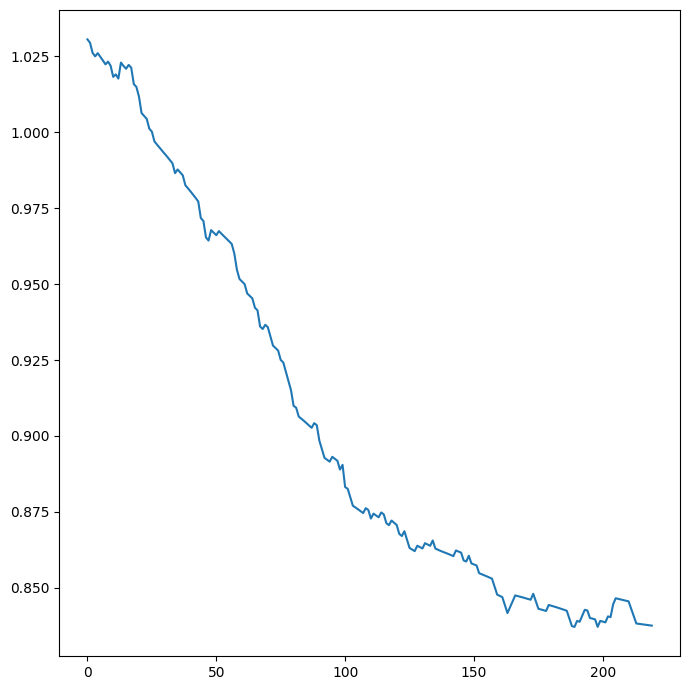

In [41]:
plt.plot(loss_over_time)
plt.show()

In [42]:
params

tensor([ 2.39512883,  1.3172053 ,  0.44037629, -0.19020969,  0.1648416 ,
         0.12669485], requires_grad=True)

In [43]:

op_state = []
X,Y,Z=[],[],[]
markers=[]
colors=[]
for i in range(len(train_X)):
    x,y,z = (get_state(train_X[i],params))
    X.append(x)
    Y.append(y)
    Z.append(z)
    if train_y[i]==1:
        markers.append("o")
        colors.append('b')
    else:
        markers.append("^")
        colors.append('r')
    op_state.append([y,z])
op_state = np.array(op_state)
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)




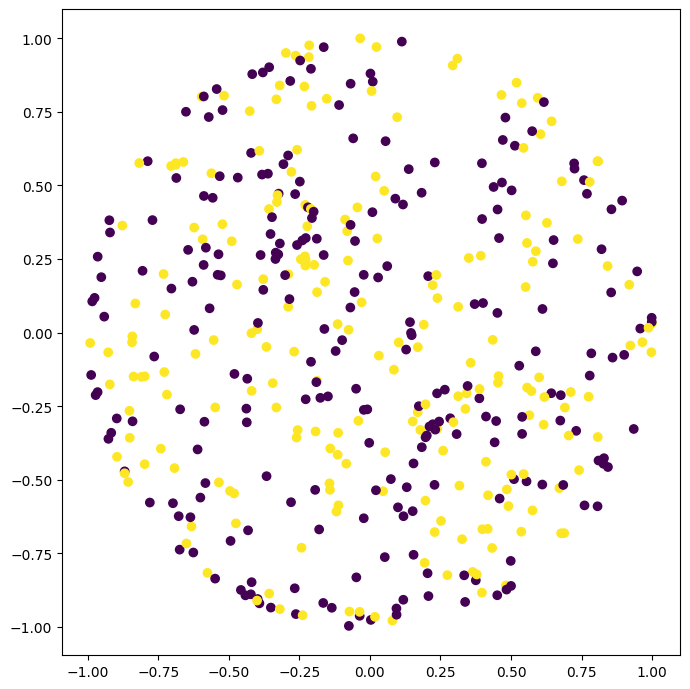

In [44]:
plot_2d_data(op_state,train_y)

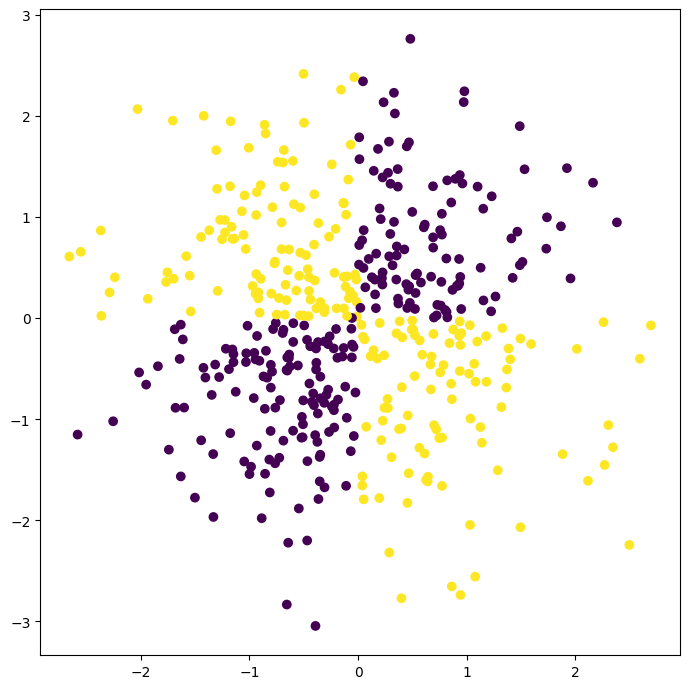

In [45]:
plot_2d_data(train_X,train_y)

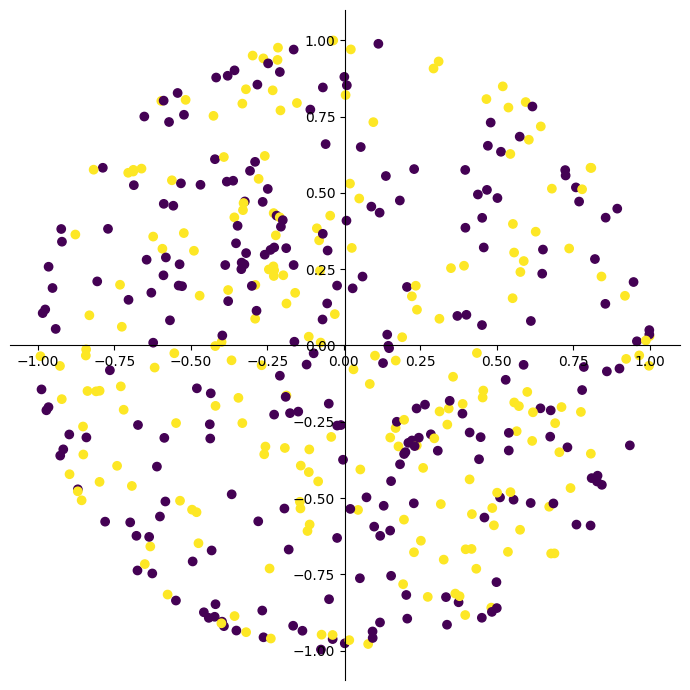

In [46]:
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.scatter(op_state[:, 0], op_state[:, 1], c=train_y)
# plt.legend(loc=1)
plt.show()

In [17]:
# https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html
# when benchmarking the WINE and IRIS for ternary classification